In [17]:
%matplotlib inline
import math
import numpy as np
# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from IPython.display import HTML
import random

from pydrake.all import (DirectCollocation, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult)
from underactuated import (
#     FindResource, 
    PlanarRigidBodyVisualizer
    
)
# import os
# def FindResource(filename):
#     return os.path.join(os.path.dirname(os.path.dirname(__file__)), filename)

# tree = RigidBodyTree(FindResource("cartpole/cartpole.urdf"),
tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree)
context = plant.CreateDefaultContext()

dircol = DirectCollocation(plant, context, num_time_samples=21,
                           minimum_timestep=0.1, maximum_timestep=0.4)

dircol.AddEqualTimeIntervalsConstraints()

initial_state = (0., 0., 0., 0.)
dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                dircol.initial_state())
# More elegant version is blocked on drake #8315:
# dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

final_state = (0., math.pi, 0., 0.)
dircol.AddBoundingBoxConstraint(final_state, final_state,
                                dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state)

R = 10  # Cost on input "effort".
u = dircol.input()
dircol.AddRunningCost(R*u[0]**2)
def f(x):
    print("hi")
    return random.random()
dircol.AddRunningCost(2*UninterpretedFunction(f, [u[0]]))


# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = \
    PiecewisePolynomial.FirstOrderHold([0., 4.],
                                       np.column_stack((initial_state,
                                                        final_state)))
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

hi


In [18]:
result = dircol.Solve()
assert(result == SolutionResult.kSolutionFound)

In [13]:
x_trajectory = dircol.ReconstructStateTrajectory()

vis = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5])
ani = vis.animate(x_trajectory, repeat=True)

# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

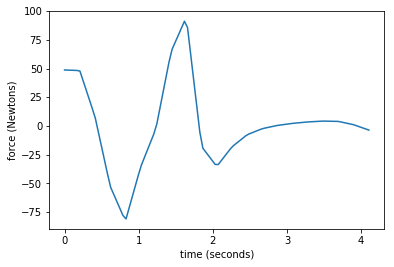

In [11]:
u_trajectory = dircol.ReconstructInputTrajectory()
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

plt.figure()
plt.plot(times, u_values)
plt.xlabel('time (seconds)')
plt.ylabel('force (Newtons)')

plt.show()